In [11]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt


In [12]:

# ---------------------------
# 1. Data Loading and Processing
# ---------------------------
def parse_path(path_str):
    """Convert a string like '0000011111' to a list of integers."""
    return [int(ch) for ch in path_str.strip()]

def interleave_partitions(mu_str, nu_str, lambda_str):
    """
    Given three partition path strings (for μ, ν, λ), interleave them:
    [μ[0], ν[0], λ[0], μ[1], ν[1], λ[1], ...]
    """
    mu = parse_path(mu_str)
    nu = parse_path(nu_str)
    lam = parse_path(lambda_str)
    L = len(mu)  # assume all paths have the same length
    interleaved = []
    for i in range(L):
        interleaved.extend([mu[i], nu[i], lam[i]])
    return interleaved

# Load dataset from JSON file
with open("lr_coefficients_matrix.json", "r") as f:
    data = json.load(f)

sequences = []
labels = []
for rec in data:
    # Note: We follow the ordering (μ, ν, λ) for interleaving.
    seq = interleave_partitions(rec["mu_path"], rec["nu_path"], rec["lambda_path"])
    sequences.append(seq)
    # Binary label: 1 if lr_coefficient is nonzero, 0 otherwise.
    labels.append(1 if rec["lr_coefficient"] != 0 else 0)

sequences = np.array(sequences)  # shape: (num_samples, seq_len)
labels = np.array(labels).astype(np.float32)  # shape: (num_samples,)

# Determine vocabulary size (assumes tokens are integers; e.g. if paths are "0"/"1")
vocab_size = int(np.max(sequences)) + 1
seq_len = sequences.shape[1]  # should equal 3 * (length of one path)


In [16]:

# ---------------------------
# 2. Create a Dataset and DataLoader
# ---------------------------
class TransformerDataset(Dataset):
    def __init__(self, sequences, labels):
        # Inputs for transformer: integer tokens.
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

dataset = TransformerDataset(sequences, labels)
# Split: ≈67% training, 33% testing.
test_size = int(0.33 * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


In [20]:

# ---------------------------
# 3. Define a Smaller Transformer Model
# ---------------------------
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, seq_len, embed_dim=32, num_heads=2, num_layers=1, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        # Token embedding
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        # Learned positional embedding
        self.pos_embedding = nn.Embedding(seq_len, embed_dim)
        # Transformer encoder with a reduced number of layers
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # Pool over the context window (mean pooling) and output a single logit.
        self.fc = nn.Linear(embed_dim, 1)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len)
        batch_size, seq_len = x.size()
        token_emb = self.token_embedding(x)  # (batch_size, seq_len, embed_dim)
        positions = torch.arange(0, seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        pos_emb = self.pos_embedding(positions)
        x_emb = token_emb + pos_emb
        # Transformer expects input shape: (seq_len, batch_size, embed_dim)
        x_emb = x_emb.transpose(0, 1)
        encoded = self.transformer_encoder(x_emb)  # (seq_len, batch_size, embed_dim)
        encoded = encoded.transpose(0, 1)  # (batch_size, seq_len, embed_dim)
        pooled = encoded.mean(dim=1)  # Mean pooling over the sequence
        logits = self.fc(pooled)  # (batch_size, 1)
        return logits

model = TransformerClassifier(vocab_size=vocab_size, seq_len=seq_len, embed_dim=32, num_heads=2, num_layers=2)
print("Model architecture:\n", model)


Model architecture:
 TransformerClassifier(
  (token_embedding): Embedding(2, 32)
  (pos_embedding): Embedding(30, 32)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [21]:

# ---------------------------
# 4. Training Setup
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.95), eps=1e-8)
num_epochs = 50  # Adjust epochs for a smaller model run
clip_norm = 1.0

def compute_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            logits = model(batch_x)
            preds = (torch.sigmoid(logits) >= 0.5).float()
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)
    return correct / total

train_loss_curve = []
train_acc_curve = []
test_loss_curve = []
test_acc_curve = []

for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}/{num_epochs}...")
    model.train()
    running_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        logits = model(batch_x)
        loss = criterion(logits, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
        optimizer.step()
        running_loss += loss.item() * batch_x.size(0)
    train_loss = running_loss / len(train_dataset)
    train_acc = compute_accuracy(train_loader, model)
    test_acc = compute_accuracy(test_loader, model)
    
    # Compute test loss
    model.eval()
    test_loss_running = 0.0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            logits = model(batch_x)
            loss = criterion(logits, batch_y)
            test_loss_running += loss.item() * batch_x.size(0)
    test_loss = test_loss_running / len(test_dataset)
    
    train_loss_curve.append(train_loss)
    test_loss_curve.append(test_loss)
    train_acc_curve.append(train_acc)
    test_acc_curve.append(test_acc)
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}, "
              f"Train Acc = {train_acc*100:.2f}%, Test Acc = {test_acc*100:.2f}%")


Starting epoch 1/50...
Epoch 1/50: Train Loss = 0.5832, Test Loss = 0.5658, Train Acc = 74.18%, Test Acc = 75.09%
Starting epoch 2/50...
Starting epoch 3/50...
Starting epoch 4/50...
Starting epoch 5/50...
Epoch 5/50: Train Loss = 0.5540, Test Loss = 0.5456, Train Acc = 74.18%, Test Acc = 75.09%
Starting epoch 6/50...
Starting epoch 7/50...
Starting epoch 8/50...
Starting epoch 9/50...
Starting epoch 10/50...
Epoch 10/50: Train Loss = 0.5314, Test Loss = 0.5311, Train Acc = 74.19%, Test Acc = 75.00%
Starting epoch 11/50...
Starting epoch 12/50...
Starting epoch 13/50...
Starting epoch 14/50...
Starting epoch 15/50...
Epoch 15/50: Train Loss = 0.4507, Test Loss = 0.4458, Train Acc = 78.10%, Test Acc = 76.97%
Starting epoch 16/50...
Starting epoch 17/50...
Starting epoch 18/50...
Starting epoch 19/50...
Starting epoch 20/50...
Epoch 20/50: Train Loss = 0.4034, Test Loss = 0.3943, Train Acc = 80.19%, Test Acc = 79.82%
Starting epoch 21/50...
Starting epoch 22/50...
Starting epoch 23/50...

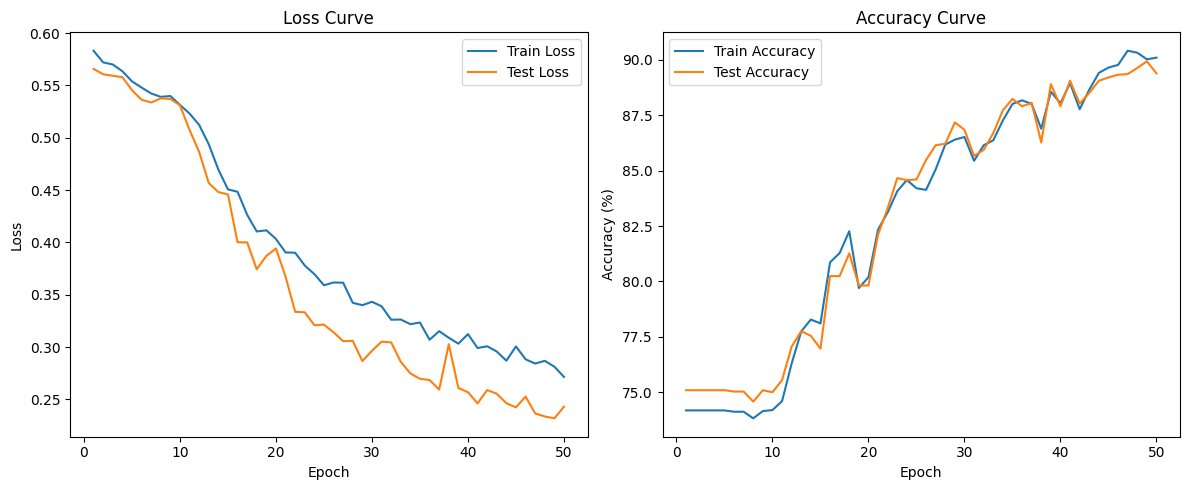

In [22]:

# ---------------------------
# 5. Plot Loss and Accuracy Curves
# ---------------------------
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_curve, label="Train Loss")
plt.plot(epochs, test_loss_curve, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, [acc*100 for acc in train_acc_curve], label="Train Accuracy")
plt.plot(epochs, [acc*100 for acc in test_acc_curve], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()
plt.tight_layout()
plt.show()


Model architecture:
 SmallTransformerClassifier(
  (token_embedding): Embedding(2, 16)
  (pos_embedding): Embedding(30, 16)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=16, bias=True)
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=16, out_features=1, bias=True)
)
Starting epoch 1/5...
Epoch 1/5: Train Loss = 0.5798, Test Loss = 0.5648, Train Acc = 74.18%, Test Acc = 75.0

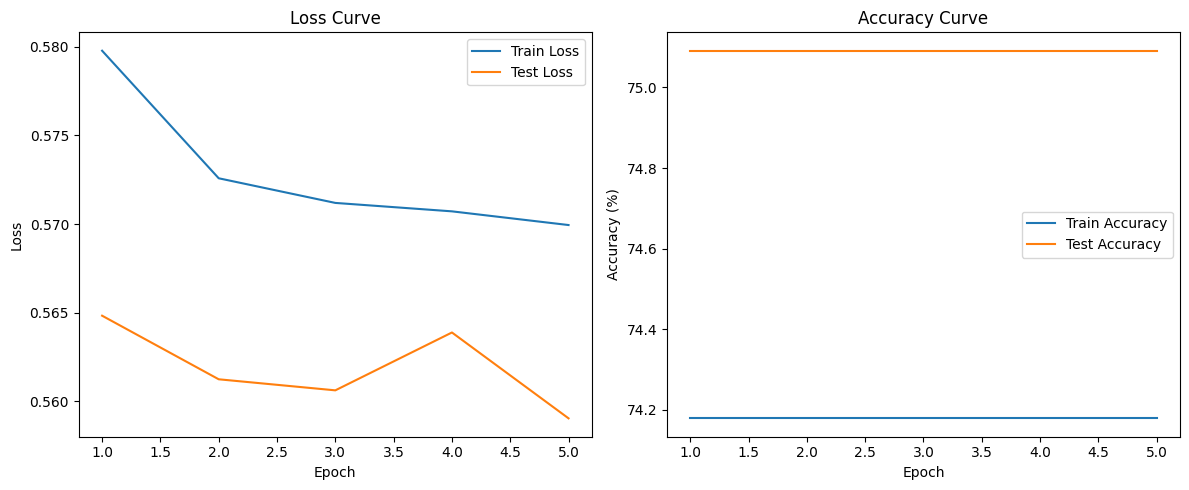

In [19]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

# ---------------------------
# 1. Data Loading and Processing
# ---------------------------
def parse_path(path_str):
    """Convert a string like '0000011111' to a list of integers."""
    return [int(ch) for ch in path_str.strip()]

def interleave_partitions(mu_str, nu_str, lambda_str):
    """
    Given three partition path strings (for μ, ν, λ), interleave them:
    [μ[0], ν[0], λ[0], μ[1], ν[1], λ[1], ...]
    """
    mu = parse_path(mu_str)
    nu = parse_path(nu_str)
    lam = parse_path(lambda_str)
    L = len(mu)  # assume all paths have the same length
    interleaved = []
    for i in range(L):
        interleaved.extend([mu[i], nu[i], lam[i]])
    return interleaved

# Load dataset from JSON file
with open("lr_coefficients_matrix.json", "r") as f:
    data = json.load(f)

sequences = []
labels = []
for rec in data:
    # Using order (μ, ν, λ)
    seq = interleave_partitions(rec["mu_path"], rec["nu_path"], rec["lambda_path"])
    sequences.append(seq)
    labels.append(1 if rec["lr_coefficient"] != 0 else 0)

sequences = np.array(sequences)  # shape: (num_samples, seq_len)
labels = np.array(labels).astype(np.float32)

# Determine vocabulary size (assuming tokens are integers, e.g. 0 or 1)
vocab_size = int(np.max(sequences)) + 1
seq_len = sequences.shape[1]

# ---------------------------
# 2. Create Dataset and DataLoader
# ---------------------------
class TransformerDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

dataset = TransformerDataset(sequences, labels)

# For debugging, you might train on a subset (e.g., first 10000 samples)
subset_size = 10000
dataset = torch.utils.data.Subset(dataset, np.arange(subset_size))

# Split: ≈67% train, 33% test
test_size = int(0.33 * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
batch_size = 128
# Use num_workers=0 to avoid multiprocessing issues
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# ---------------------------
# 3. Define a Smaller Transformer Model
# ---------------------------
class SmallTransformerClassifier(nn.Module):
    def __init__(self, vocab_size, seq_len, embed_dim=16, num_heads=2, num_layers=1, dropout=0.1):
        super(SmallTransformerClassifier, self).__init__()
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_embedding = nn.Embedding(seq_len, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, 1)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len)
        batch_size, seq_len = x.size()
        token_emb = self.token_embedding(x)  # (batch_size, seq_len, embed_dim)
        positions = torch.arange(0, seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        pos_emb = self.pos_embedding(positions)
        x_emb = token_emb + pos_emb
        x_emb = x_emb.transpose(0, 1)  # shape: (seq_len, batch_size, embed_dim)
        encoded = self.transformer_encoder(x_emb)
        encoded = encoded.transpose(0, 1)  # (batch_size, seq_len, embed_dim)
        pooled = encoded.mean(dim=1)
        logits = self.fc(pooled)
        return logits

model = SmallTransformerClassifier(vocab_size=vocab_size, seq_len=seq_len, embed_dim=16, num_heads=2, num_layers=1)
print("Model architecture:\n", model)

# ---------------------------
# 4. Training Setup
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.95), eps=1e-8)
num_epochs = 5  # reduced epochs for quick debugging
clip_norm = 1.0

def compute_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            logits = model(batch_x)
            preds = (torch.sigmoid(logits) >= 0.5).float()
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)
    return correct / total

train_loss_curve = []
train_acc_curve = []
test_loss_curve = []
test_acc_curve = []

for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}/{num_epochs}...")
    model.train()
    running_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        logits = model(batch_x)
        loss = criterion(logits, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
        optimizer.step()
        running_loss += loss.item() * batch_x.size(0)
    train_loss = running_loss / len(train_dataset)
    train_acc = compute_accuracy(train_loader, model)
    test_acc = compute_accuracy(test_loader, model)
    
    model.eval()
    test_loss_running = 0.0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            logits = model(batch_x)
            loss = criterion(logits, batch_y)
            test_loss_running += loss.item() * batch_x.size(0)
    test_loss = test_loss_running / len(test_dataset)
    
    train_loss_curve.append(train_loss)
    test_loss_curve.append(test_loss)
    train_acc_curve.append(train_acc)
    test_acc_curve.append(test_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}, "
          f"Train Acc = {train_acc*100:.2f}%, Test Acc = {test_acc*100:.2f}%")

# ---------------------------
# 5. Plot Loss and Accuracy Curves
# ---------------------------
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_curve, label="Train Loss")
plt.plot(epochs, test_loss_curve, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, [acc*100 for acc in train_acc_curve], label="Train Accuracy")
plt.plot(epochs, [acc*100 for acc in test_acc_curve], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()
plt.tight_layout()
plt.show()
